# Неделя 7. Градиентный бустинг.

[Ссылка на форму с вопросами](https://forms.gle/gPevc4GKscG2wiWo6) 

Дэдлайн: **8.04.20** включительно. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from xgboost import XGBRegressor

%pylab inline

RANDOM_SEED = 0

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Проверка версий библиотек
# Sklearn: 0.22.1,
# XGBoost: 1.0.2
# hyperopt: 0.2.3
import xgboost
import sklearn
import hyperopt
print('Sklearn: {},\nXGBoost: {},\nhyperopt: {}'.format(sklearn.__version__, 
                                                        xgboost.__version__, 
                                                        hyperopt.__version__))

Sklearn: 0.21.3,
XGBoost: 0.90,
hyperopt: 0.2.3


## Данные для эксперимента

In [3]:
# Загрузим датасет california_housing
clf_dataset = fetch_california_housing()

In [4]:
data = clf_dataset.data
target = clf_dataset.target
data.shape, target.shape

((20640, 8), (20640,))

In [5]:
# Сделаем случайную выборку из 2000 объектов
n_samples = 2000
np.random.seed(RANDOM_SEED)
samples = np.random.choice(np.arange(data.shape[0]), n_samples, replace=False)
data = data[samples]
target = target[samples]
data.shape, target.shape

((2000, 8), (2000,))

In [6]:
# Сформируем датафрейм из новой выборки, объединив его с таргетом
full_df = pd.DataFrame(data, columns=['clm_{}'.format(i) for i in range(data.shape[1])])
full_df['target'] = target
full_df.head()

,clm_0,clm_1,clm_2,clm_3,clm_4,clm_5,clm_6,clm_7,target
0,4.1518,22.0,5.663073,1.075472,1551.0,4.180593,32.58,-117.05,1.369
1,5.7796,32.0,6.107226,0.927739,1296.0,3.020979,33.92,-117.97,2.413
2,4.3487,29.0,5.930712,1.026217,1554.0,2.910112,38.65,-121.84,2.007
3,2.4511,37.0,4.992958,1.316901,390.0,2.746479,33.20,-115.60,0.725
4,5.0049,25.0,4.319261,1.039578,649.0,1.712401,37.79,-122.43,4.600


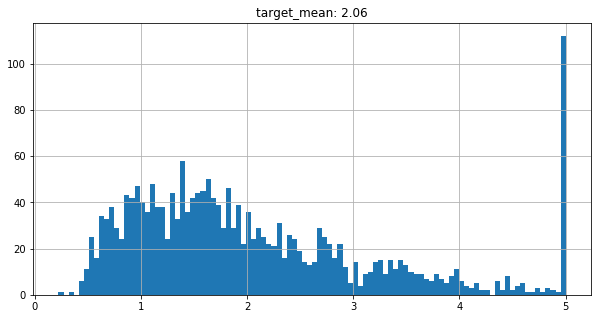

In [7]:
# Посмотрим на таргет
plt.figure(figsize=(10,5))
plt.title('target_mean: {}'.format(round(full_df['target'].mean(), 3)))
full_df['target'].hist(bins=100);

- Таргет вещественный, значит будем решать задачу регрессии.
- Есть выброс в районе 5, на который пока не обращаем внимание.

In [8]:
# Разделим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(full_df.drop('target', axis=1), 
                                                    full_df['target'], 
                                                    test_size=0.3, 
                                                    random_state=RANDOM_SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1400, 8), (600, 8), (1400,), (600,))

## Константная модель

In [9]:
y_trn_pred = [y_train.mean()]*len(y_train)
y_tst_pred = [y_train.mean()]*len(y_test)
mse_train = mean_squared_error(y_train, y_trn_pred)
mse_test = mean_squared_error(y_test, y_tst_pred)
print('rmse_train: {}, rmse_test: {}'.format(round(np.sqrt(mse_train), 3), round(np.sqrt(mse_test), 3)))

rmse_train: 1.184, rmse_test: 1.161


- Пока полученные цифры нам мало о чем говорят, разве что train и test выборки сбалансированные, так как метрики на train и test близки.
- Но мы можем зафиксировать значение mse_test = 1.16 как бейзлайн, на который будем ориентироваться при построение более сложных моделей.

## Реализация градиентного бустинга

### Определим функцию для расчета вектора сдвигов S
Выберем в качестве функции потерь MSE:

   \\[L=(y-y_{predict})^2\\]
    
Как известно из лекции, для вектор сдвигов представляет собой производную функции потерь, посчитанную на всем объеме выборки:

   \\[s_i =-L'(y_i, y_{predict_i})\\]
         
После вычисления производной получим следующее выражение для определения s. Множитель 2, который получился после дифференцирования квадрата разности, проигнорируем, поскольку в дальнейшем мы будем подбирать множитель базового алгоритма:

   \\[s_i=y_i-y_{predict_i}\\]   
         
    

In [10]:
# Определим функцию для расчета вектора сдвигов S
def S(y_train, y_predict):     
    return list(map(lambda x, y: (x - y), y_train, y_predict))    

### Реализуем алгоритм обучения градиентного бустинга над деревьями
Проинициализируем нашу модель бустинга следующими параметрами:
- Число деревьев: 50
- Коэффициент шага алгоритма: 1.0
- Глубина дерева: 2
- Random_state: 0

    1.Создадим список, где будут храниться наши базовые алгоритмы.
    
    2.Зададимся неким нулевым базовым алгоритмом. Например, константный алгоритм, который на выходе выдает тоже самое, что получает на вход.
    
    3.Обучим в цикле все деревья, научим их приближать вектор сдвигов, расчитанный на основе прогнозов предыдущего базового алгоритма.
    
    4.Получим итоговый прогноз как сумму прогнозов базовых алгоритмов с учетом коэффициента шага.

In [11]:
# Функция вычисления прогноза композиции алгоритмов 
def gbm_predict(X, algo_list, coeff_list):
    predict_lst = []
    for algo, coeff in zip(algo_list, coeff_list):
        predict_lst.append(coeff * algo.predict(X))
    return np.array(predict_lst).sum(axis=0)

In [12]:
# Инициализация параметров модели
n_trees = 50
max_depth = 2
eta = 1.0
eta_list = [eta] * n_trees
y0 = y_train
base_algo_list = []

# Обучение модели
for i in tqdm(range(n_trees)):
    estimator = DecisionTreeRegressor(max_depth=max_depth, random_state=RANDOM_SEED)
    base_algo_list.append(estimator.fit(X_train, S(y_train, y0)))
    y0 = gbm_predict(X_train.values, base_algo_list, eta_list)

# Ответ финальной композиции деревьев
y_pred_test = gbm_predict(X_test.values, base_algo_list, eta_list) 
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(rmse)


0.6590332227577066


### <font color='brown'> Задание №1 </font>
- Используя предложенную выше реализацию GBM, проведите следующий эксперимент: инициализируйте базовый алгоритм медианой таргета обучающей выборки и переобучите модель, обучайте бустинг не меняя параметров инициализации.
- Ответом будет результат rmse, округленный до 4 знака после запятой.

In [35]:
y_median = y_train.median()
y0 = y_train.apply(lambda x: y_median)
base_algo_list = []

for i in tqdm(range(n_trees)):
    estimator = DecisionTreeRegressor(max_depth=max_depth, random_state=RANDOM_SEED)
    base_algo_list.append(estimator.fit(X_train, S(y_train, y0)))
    y0 = gbm_predict(X_train.values, base_algo_list, eta_list)

# Ответ финальной композиции деревьев
y_pred_test = gbm_predict(X_test.values, base_algo_list, eta_list) 
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(round(rmse,4))


0.6352


### <font color='brown'> Задание №2 </font>
- Используя предложенную выше реализацию GBM, проведите следующий эксперимент: в качестве базового алгоритма примените линейную модель LinearRegression из sklearn, обучайте бустинг не меняя параметров инициализации.
- Ответье на вопрос: Как повлияла замена базовой модели на итоговую метрику rmse на отложенной выборке. Если метрика изменилась, то объясните почему она изменлась таким образом. Также в конце ответа напшите значение rmse, округленное до 3 знака.

In [36]:
base_algo_list = []
y0 = y_train.apply(lambda x: y_median)

for i in tqdm(range(n_trees)):
    estimator = LinearRegression()
    base_algo_list.append(estimator.fit(X_train, S(y_train, y0)))
    y0 = gbm_predict(X_train.values, base_algo_list, eta_list)
    
y_pred_test = gbm_predict(X_test.values, base_algo_list, eta_list) 
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(round(rmse,3))


0.746


### Оценим влияние коэффициента шага алгоритма (eta) на ошибку модели
Шаг для всех базовых алгоритмов композиции останется постоянным. Будем менять шаг eta только для всей композиции и оценим его влияние на rmse.

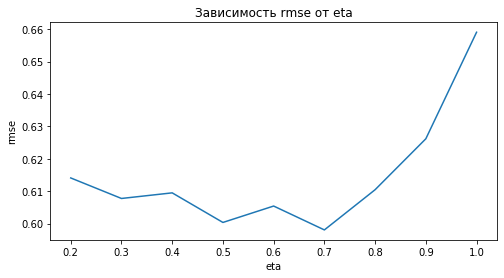

In [15]:
rmse_list = []
for eta in tqdm(np.arange(1.0, 0.1, -0.1)):
    n_trees = 50
    max_depth = 2
    y0 = y_train
    base_algo_list = []
    eta_list = [round(eta, 1)] * n_trees
    # Обучение модели
    for i in range(n_trees):
        estimator = DecisionTreeRegressor(max_depth=max_depth, random_state=RANDOM_SEED)    
        base_algo_list.append(estimator.fit(X_train, S(y_train, y0)))
        y0 = gbm_predict(X_train.values, base_algo_list, eta_list)

    # Ответ финальной композиции деревьев
    y_pred_test = gbm_predict(X_test.values, base_algo_list, eta_list) 
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    rmse_list.append(rmse)
    
plt.figure(figsize=(8,4))
plt.plot(np.arange(1.0, 0.1, -0.1), rmse_list);
plt.title('Зависимость rmse от eta')
plt.xlabel('eta')
plt.ylabel('rmse');

- После значения eta > 0.7 наша можель начинает переобучаться.  

### <font color='brown'> Задание №3 </font>
Недостаток постоянства шага для базовых алгоритмов композиции заключается в том, что ошибки вблизи минимума не могут достигнуть экстремума и постоянно перескакивют его. Поэтому желательно, чтобы с каждым шагом, для нового базового алгоритма параметр eta уменьшался.
- Реализуйте снижение шага eta для базовых алгоритмов в рамках обучения одной композиции по следующему закону:

    \\[eta_i = \frac{1.0}{1.0+0.1*i}\\]
    
    
- Ответом будет результат rmse, округленный до 3 знака после запятой.

0.9090909090909091
0.9174311926605504
0.9259259259259258
0.9345794392523364
0.9433962264150942
0.9523809523809523
0.9615384615384615
0.970873786407767
0.9803921568627451

[0.613, 0.633, 0.614, 0.629, 0.64, 0.625, 0.613, 0.655, 0.632]


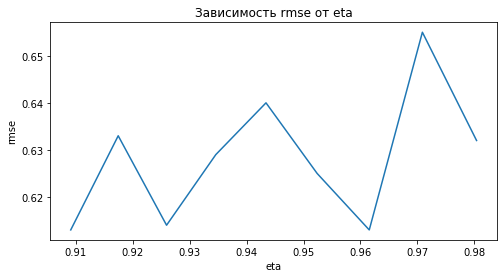

In [34]:
rmse_list_mod = []
eta = []
counter = 0
for i in tqdm(np.arange(1.0, 0.1, -0.1)):
    eta.append(1.0 / (1.0 + 0.1 * i))
    print(eta[counter])
    n_trees = 50
    max_depth = 2
    y0 = y_train
    base_algo_list = []
    eta_list = [round(eta[counter], 3)] * n_trees
    # Обучение модели
    for i in range(n_trees):
        estimator = DecisionTreeRegressor(max_depth=max_depth, random_state=RANDOM_SEED)    
        base_algo_list.append(estimator.fit(X_train, S(y_train, y0)))
        y0 = gbm_predict(X_train.values, base_algo_list, eta_list)
        
    # Ответ финальной композиции деревьев
    y_pred_test = gbm_predict(X_test.values, base_algo_list, eta_list) 
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    rmse_list_mod.append(round(rmse,3))
    counter += 1
    
plt.figure(figsize=(8,4))
plt.plot(eta, rmse_list_mod);
plt.title('Зависимость rmse от eta')
plt.xlabel('eta')
plt.ylabel('rmse');

print(rmse_list_mod)

## Работа с раличными реализациями градиентного бустинга
### Оценим влияние различных параметров градиентного бустинга на ошибку модели на примере реализации из sklearn - ***GradientBoostingRegressor***

In [17]:
print('------------------') 
print('Go for estimators..')
n_estim_list = np.arange(2,200,10)
rmse_estim = []
for estimator in tqdm(n_estim_list):
    regressor = GradientBoostingRegressor(n_estimators = estimator, max_depth = 20, random_state=RANDOM_SEED)
    regressor.fit(X_train, y_train)
    rmse_estim.append(np.sqrt(mean_squared_error(y_test, regressor.predict(X_test)))) 

print('------------------')   
print('Go for max_depth..')
max_depth_list = np.arange(1,100,10)
rmse_depth = []
for depth in tqdm(max_depth_list):
    regressor = GradientBoostingRegressor(n_estimators = 50, max_depth = depth)
    regressor.fit(X_train, y_train)
    rmse_depth.append(np.sqrt(mean_squared_error(y_test, regressor.predict(X_test))))

------------------
Go for estimators..



------------------
Go for max_depth..


Text(0.5, 1.0, 'RMSE for depth')

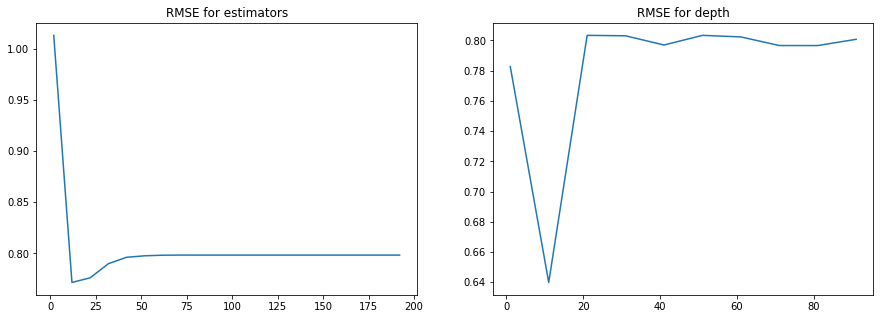

In [18]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(n_estim_list, rmse_estim)
pyplot.title('RMSE for estimators')
    
plt.subplot(1,2,2)
pyplot.plot(max_depth_list, rmse_depth)
pyplot.title('RMSE for depth')

- С увеличением числа деревьев, начиная с некоторого момента, градиентный бустинг начинает переобучаться.
- С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга на тестовой выборке также начинает ухудшаться, то есть модель переобучается.


### <font color='brown'> Задание №4 </font>
Оцените влияние параметра ***learning_rate*** (аналог eta) рассмотренной выше модели ***GradientBoostingRegressor*** на RMSE.
- Зафиксируйте параметры модели: n_estimators = 100, max_depth = 2, random_state=RANDOM_SEED.
- Постройте изменение RMSE в зависимости от ***learning_rate*** в диапазоне от 0.1 до 1.0 (включительно) с шагом 0.1 для train и test выборок.
- Оцените значение ***learning_rate*** при котором начинается переобучение.

In [19]:
learning_rate_values = np.arange(0.1, 1.1, 0.1) 
rmse_lr = []

for lr in tqdm(learning_rate_values):
    regressor = GradientBoostingRegressor(n_estimators = 100, max_depth=2, learning_rate=lr, random_state=RANDOM_SEED)
    regressor.fit(X_train, y_train)
    rmse_lr.append(np.sqrt(mean_squared_error(y_test, regressor.predict(X_test))))

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


Text(0.5, 0, 'learning_rate')

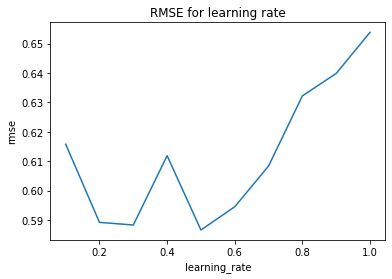

In [20]:
print(learning_rate_values)
plt.plot(learning_rate_values, rmse_lr)
plt.title('RMSE for learning rate')
plt.ylabel('rmse')
plt.xlabel('learning_rate')

## XGBoost
### Рассмотрим некоторые удобные функции библиотеки XGBoost:
- Останов по значению метрики на валидации.
- Визуализация.
- Важность признаков


In [21]:
# Обучим модель XGBRegressor c заданным параметром early_stopping_rounds
xgb = XGBRegressor(n_estimators=1000, random_state=RANDOM_SEED)
xgb.fit(X_train, y_train,
        eval_set=[(X_train, y_train),(X_test, y_test)],
        eval_metric='rmse',
        verbose=True,
        early_stopping_rounds=10
        )

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:45:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.80319	validation_1-rmse:1.77049
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.65747	validation_1-rmse:1.63116
[2]	validation_0-rmse:1.5298	validation_1-rmse:1.51029
[3]	validation_0-rmse:1.41583	validation_1-rmse:1.40453
[4]	validation_0-rmse:1.31527	validation_1-rmse:1.30982
[5]	validation_0-rmse:1.22703	validation_1-rmse:1.22537
[6]	validation_0-rmse:1.14886	validation_1-rmse:1.15623
[7]	validation_0-rmse:1.08034	validation_1-rmse:1.09165
[8]	validation_0-rmse:1.02077	validation_1-rmse:1.03691
[9]	validation_0-rmse:0.968407	validation_1-rmse:0.991251
[10]	validation_0-rmse:0.922187	validation_1-rmse:0.949035
[11]	validation_0-rmse:0.881363	validation_1-rmse:0.913705
[12]	validation_0-rmse:0.844618	validation_1-r

[135]	validation_0-rmse:0.380651	validation_1-rmse:0.581825
[136]	validation_0-rmse:0.379608	validation_1-rmse:0.581348
[137]	validation_0-rmse:0.378719	validation_1-rmse:0.581187
[138]	validation_0-rmse:0.376784	validation_1-rmse:0.580553
[139]	validation_0-rmse:0.375546	validation_1-rmse:0.580822
[140]	validation_0-rmse:0.374886	validation_1-rmse:0.580291
[141]	validation_0-rmse:0.374125	validation_1-rmse:0.579764
[142]	validation_0-rmse:0.371809	validation_1-rmse:0.578289
[143]	validation_0-rmse:0.371321	validation_1-rmse:0.577949
[144]	validation_0-rmse:0.37111	validation_1-rmse:0.578668
[145]	validation_0-rmse:0.370741	validation_1-rmse:0.578891
[146]	validation_0-rmse:0.369972	validation_1-rmse:0.579047
[147]	validation_0-rmse:0.369526	validation_1-rmse:0.578914
[148]	validation_0-rmse:0.3682	validation_1-rmse:0.57834
[149]	validation_0-rmse:0.367996	validation_1-rmse:0.578877
[150]	validation_0-rmse:0.367238	validation_1-rmse:0.578271
[151]	validation_0-rmse:0.366636	validation_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

- Обучение было остановлено, после того как ошибка rmse не уменьшалась на тестовой выборке в течении **10** итерации.


In [22]:
xgb.best_score

0.566111

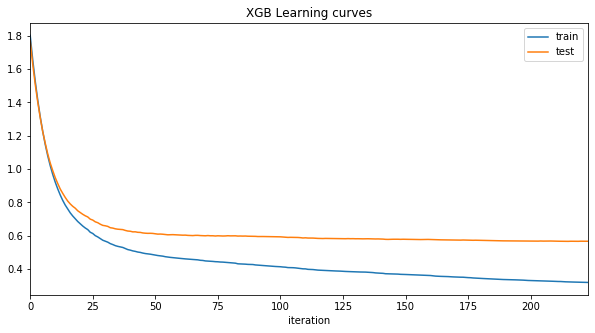

In [23]:
# Построим кривые обучения и валидации с помощью встроенных в XGBoost методов оценки ошибки. 
eval_results = xgb.evals_result()
train_error = eval_results['validation_0']['rmse']
test_error = eval_results['validation_1']['rmse']
df_error = pd.DataFrame([train_error, test_error]).T
df_error.columns = ['train', 'test']
df_error.index.name = 'iteration'
# Plot curves
df_error.plot(title = 'XGB Learning curves', figsize=(10,5));

- По кривым обучения видно, что применение раннего останова обучения позволило избежать переобучения модели.


### <font color='brown'> Задание №5 </font>
Работа с встроенной функцией Feature_importance
- С помощью встроенной в xgboost функции определения важности признаков найдите топ 4 важных признаков и переобучите на них модель.
- Ответом будет метрика rmse, полученная новой моделью на тестовой выборке. Ответ округлите до 3-го знака. 

In [24]:
best_features = xgb.feature_importances_[:4]
print(best_features)
importance_type = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
xgb.get_booster().get_score(importance_type='total_gain')

[0.5244073  0.05500259 0.03026315 0.0365083 ]


{'clm_0': 5274.16163170655,
 'clm_6': 924.8557077926006,
 'clm_5': 1266.6488212751,
 'clm_2': 243.2225641985001,
 'clm_1': 308.6951464954,
 'clm_7': 1115.3138050559005,
 'clm_3': 157.3618960477899,
 'clm_4': 164.92037671989993}

In [25]:
X_importance_train = X_train.drop(['clm_1','clm_2','clm_3','clm_4'], axis=1)
X_importance_test = X_test.drop(['clm_1','clm_2','clm_3','clm_4'], axis=1)
xgb_importance = XGBRegressor(n_estimators=1000, random_state=RANDOM_SEED)
xgb_importance.fit(X_importance_train, y_train,
        eval_set=[(X_importance_train, y_train),(X_importance_test, y_test)],
        eval_metric='rmse',
        verbose=True,
        early_stopping_rounds=10
        )

[19:45:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.80319	validation_1-rmse:1.77049
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.65747	validation_1-rmse:1.63116
[2]	validation_0-rmse:1.5298	validation_1-rmse:1.51029
[3]	validation_0-rmse:1.41583	validation_1-rmse:1.40453
[4]	validation_0-rmse:1.31527	validation_1-rmse:1.30982
[5]	validation_0-rmse:1.22731	validation_1-rmse:1.22576
[6]	validation_0-rmse:1.14922	validation_1-rmse:1.15673
[7]	validation_0-rmse:1.08094	validation_1-rmse:1.09281
[8]	validation_0-rmse:1.02173	validation_1-rmse:1.03849
[9]	validation_0-rmse:0.970138	validation_1-rmse:0.991533
[10]	validation_0-rmse:0.922112	validation_1-rmse:0.950885
[11]	validation_0-rmse:0.882091	validation_1-rmse:0.913413
[12]	validation_0-rmse:0.846066	validation_1-r

[135]	validation_0-rmse:0.413164	validation_1-rmse:0.573075
[136]	validation_0-rmse:0.411487	validation_1-rmse:0.572706
[137]	validation_0-rmse:0.410923	validation_1-rmse:0.572437
[138]	validation_0-rmse:0.410662	validation_1-rmse:0.572368
[139]	validation_0-rmse:0.409922	validation_1-rmse:0.572141
[140]	validation_0-rmse:0.409332	validation_1-rmse:0.57255
[141]	validation_0-rmse:0.408676	validation_1-rmse:0.572435
[142]	validation_0-rmse:0.407267	validation_1-rmse:0.572277
[143]	validation_0-rmse:0.406414	validation_1-rmse:0.571887
[144]	validation_0-rmse:0.405	validation_1-rmse:0.571388
[145]	validation_0-rmse:0.403706	validation_1-rmse:0.571039
[146]	validation_0-rmse:0.403187	validation_1-rmse:0.571053
[147]	validation_0-rmse:0.402574	validation_1-rmse:0.570979
[148]	validation_0-rmse:0.401475	validation_1-rmse:0.570822
[149]	validation_0-rmse:0.400228	validation_1-rmse:0.570185
[150]	validation_0-rmse:0.399474	validation_1-rmse:0.570351
[151]	validation_0-rmse:0.398819	validation_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [26]:
xgb_importance.best_score

0.566519

### Тюнинг гиперпараметров XGBoost c помощью бибилиотеки hyperopt
Основные параметры:

- learning_rate: шаг обучения;
- max_depth: максимальная глубина дерева.

Параметры семплинга:

- subsample: доля объектов выборки, на которых обучается одно дерево;
- colsample_bytree: доля признаков, на которых обучается одно дерево.

Параметры регуляризации:

- min_child_weight: в задаче регресии - минимальное число листьев в одной ветке дерева;
- gamma: коэффициент, который ограничивает число листьев во всем дереве;
- lambda: L2 - регуляризация весов в листьях;
- alpha: L1 - регуляриазция весов в листьях.

Регуляризация в XGBoost:

\\[L(y,z)+\gamma*J + \frac{\lambda}{2}\Sigma_{j=1}^{J}b_j^2\\]

где J - число листьев в дереве, b - вес в листе.


In [27]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
np.random.seed(RANDOM_SEED)

# XGB parameters for tune
space = {
    'learning_rate': hp.choice('learning_rate',    np.arange(0.01, 0.5, 0.01)),
    'max_depth': hp.choice('max_depth',        np.arange(4, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 10, 1, dtype=int)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_lambda': hp.choice('reg_lambda', np.logspace(-1.0, 2.0, num=100)),
    #'n_estimators': hp.choice('n_estimators',  np.arange(30, 200, 10, dtype=int))
}

# RMSE Cross-validation 
def cv_scores(estimator, X, y, cv=3):
    skf = KFold(n_splits=cv, shuffle=True, random_state=RANDOM_SEED)
    scores=[]
    for train_index, val_index in skf.split(X, y):
        estimator.fit(X.iloc[train_index], y.iloc[train_index])
        y_pred  = estimator.predict(X.iloc[val_index])
        scores.append(np.sqrt(mean_squared_error(y.iloc[val_index], y_pred)))
    return np.mean(scores)

# RMSE test 
def test_scores(estimator, X_train, y_train, X_test, y_test):
    estimator.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              eval_metric = 'rmse',
              early_stopping_rounds = 10,
              verbose = False
             )    
    scores = np.sqrt(mean_squared_error(y_test, estimator.predict(X_test))) 
    return scores, estimator.best_iteration
    
    
def hyperopt_objective(space):
        
    model = XGBRegressor(
        learning_rate = space['learning_rate'],
        max_depth = space['max_depth'],
        min_child_weight = space['min_child_weight'],
        colsample_bytree = space['colsample_bytree'],
        reg_lambda = space['reg_lambda'],
        random_state = RANDOM_SEED,
        n_estimators = 1000 #space['n_estimators']
                        
    )    
    #scores = cv_scores(model, X_train, y_train, cv=3)
    #return np.mean(scores)
    
    scores, best_iteration = test_scores(model, X_train, y_train, X_test, y_test)    
    return {'loss': scores, 'best_iteration': best_iteration, 'status': STATUS_OK}
    
    
trials = Trials()
best_params = fmin(fn = hyperopt_objective,
                   space = space,
                   algo = tpe.suggest,
                   max_evals = 100,
                   trials = trials,
                   verbose = 2,
                   rstate = np.random.seed(RANDOM_SEED),
                   return_argmin=False
                  )

print('Best params:\n', best_params)

[19:45:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
  1%|▍                                                | 1/100 [00:00<00:11,  8.78trial/s, best loss: 0.645628095131159]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
  1%|▍                                                | 1/100 [00:00<00:11,  8.78trial/s, best loss: 0.645628095131159]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
  3%|█▍                                              | 3/100 [00:00<00:11,  8.26trial/s, best loss: 0.6068232231037392]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
  4%|█▉                                              | 4/100 [00:00<00:22,  4.34trial/s, best loss: 0.5440969179331584]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
  5%|██▍                                             | 5/100 [00:01<00:43,  2.17trial/s, best loss: 0.5364874583450472]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
  6%|██▉                                             | 6/100 [00:02<00:40,  2.32trial/s, best loss: 0.5364874583450472]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
  7%|███▎                                            | 7/100 [00:02<00:32,  2.86trial/s, best loss: 0.5364874583450472]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
  8%|███▊                                            | 8/100 [00:02<00:27,  3.35trial/s, best loss: 0.5364874583450472]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
  9%|████▎                                           | 9/100 [00:02<00:22,  3.98trial/s, best loss: 0.5364874583450472]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 10%|████▋                                          | 10/100 [00:02<00:22,  3.93trial/s, best loss: 0.5248912813088241]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 11%|█████▏                                         | 11/100 [00:03<00:22,  4.00trial/s, best loss: 0.5248912813088241]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 11%|█████▏                                         | 11/100 [00:03<00:22,  4.00trial/s, best loss: 0.5248912813088241]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 13%|██████                                         | 13/100 [00:03<00:18,  4.59trial/s, best loss: 0.5248912813088241]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 14%|██████▌                                        | 14/100 [00:03<00:18,  4.60trial/s, best loss: 0.5248912813088241]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 15%|███████                                        | 15/100 [00:03<00:18,  4.57trial/s, best loss: 0.5248912813088241]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 16%|███████▌                                       | 16/100 [00:04<00:19,  4.27trial/s, best loss: 0.5248912813088241]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 17%|███████▉                                       | 17/100 [00:04<00:17,  4.74trial/s, best loss: 0.5248912813088241]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 18%|████████▍                                      | 18/100 [00:04<00:17,  4.80trial/s, best loss: 0.5248912813088241]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 19%|████████▉                                      | 19/100 [00:04<00:17,  4.52trial/s, best loss: 0.5248912813088241]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 20%|█████████▍                                     | 20/100 [00:04<00:14,  5.36trial/s, best loss: 0.5248912813088241]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 21%|█████████▊                                     | 21/100 [00:05<00:18,  4.17trial/s, best loss: 0.5248912813088241]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 22%|██████████▎                                    | 22/100 [00:05<00:21,  3.64trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 23%|██████████▊                                    | 23/100 [00:05<00:19,  4.01trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 24%|███████████▎                                   | 24/100 [00:06<00:20,  3.75trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 25%|███████████▊                                   | 25/100 [00:06<00:25,  2.96trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 26%|████████████▏                                  | 26/100 [00:06<00:24,  2.97trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 27%|████████████▋                                  | 27/100 [00:08<00:39,  1.83trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 28%|█████████████▏                                 | 28/100 [00:08<00:32,  2.24trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 29%|█████████████▋                                 | 29/100 [00:08<00:29,  2.39trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 30%|██████████████                                 | 30/100 [00:08<00:24,  2.83trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 31%|██████████████▌                                | 31/100 [00:08<00:20,  3.35trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 32%|███████████████                                | 32/100 [00:09<00:17,  3.95trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 33%|███████████████▌                               | 33/100 [00:09<00:18,  3.62trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 34%|███████████████▉                               | 34/100 [00:09<00:20,  3.25trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 35%|████████████████▍                              | 35/100 [00:10<00:20,  3.17trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 36%|████████████████▉                              | 36/100 [00:11<00:47,  1.35trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 37%|█████████████████▍                             | 37/100 [00:11<00:34,  1.82trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 38%|█████████████████▊                             | 38/100 [00:13<00:48,  1.28trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 39%|██████████████████▎                            | 39/100 [00:16<01:23,  1.37s/trial, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 40%|██████████████████▊                            | 40/100 [00:16<01:01,  1.02s/trial, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 41%|███████████████████▎                           | 41/100 [00:16<00:45,  1.29trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 42%|███████████████████▋                           | 42/100 [00:16<00:33,  1.72trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 43%|████████████████████▏                          | 43/100 [00:16<00:26,  2.11trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 44%|████████████████████▋                          | 44/100 [00:17<00:22,  2.54trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 45%|█████████████████████▏                         | 45/100 [00:17<00:19,  2.87trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 46%|█████████████████████▌                         | 46/100 [00:17<00:14,  3.61trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 47%|██████████████████████                         | 47/100 [00:17<00:12,  4.32trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 48%|██████████████████████▌                        | 48/100 [00:17<00:12,  4.03trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 49%|███████████████████████                        | 49/100 [00:18<00:19,  2.66trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 50%|███████████████████████▌                       | 50/100 [00:18<00:16,  3.05trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 51%|███████████████████████▉                       | 51/100 [00:18<00:13,  3.74trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 52%|████████████████████████▍                      | 52/100 [00:19<00:12,  3.76trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 52%|████████████████████████▍                      | 52/100 [00:19<00:12,  3.76trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 54%|█████████████████████████▍                     | 54/100 [00:19<00:10,  4.52trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 54%|█████████████████████████▍                     | 54/100 [00:19<00:10,  4.52trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 56%|██████████████████████████▎                    | 56/100 [00:22<00:25,  1.74trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 57%|██████████████████████████▊                    | 57/100 [00:22<00:24,  1.75trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 58%|███████████████████████████▎                   | 58/100 [00:23<00:22,  1.89trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 59%|███████████████████████████▋                   | 59/100 [00:23<00:16,  2.49trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 60%|████████████████████████████▏                  | 60/100 [00:23<00:12,  3.11trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 61%|████████████████████████████▋                  | 61/100 [00:23<00:12,  3.22trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 62%|█████████████████████████████▏                 | 62/100 [00:24<00:17,  2.16trial/s, best loss: 0.5157680672900047]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 63%|█████████████████████████████▌                 | 63/100 [00:25<00:21,  1.71trial/s, best loss: 0.5149164965829224]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 64%|██████████████████████████████▋                 | 64/100 [00:26<00:25,  1.40trial/s, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 65%|███████████████████████████████▏                | 65/100 [00:27<00:27,  1.28trial/s, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:45:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 66%|███████████████████████████████▋                | 66/100 [00:28<00:29,  1.17trial/s, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:46:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 67%|████████████████████████████████▏               | 67/100 [00:28<00:25,  1.30trial/s, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:46:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 68%|████████████████████████████████▋               | 68/100 [00:29<00:23,  1.35trial/s, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:46:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 69%|█████████████████████████████████               | 69/100 [00:30<00:23,  1.34trial/s, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:46:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 70%|█████████████████████████████████▌              | 70/100 [00:31<00:27,  1.08trial/s, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:46:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 71%|██████████████████████████████████              | 71/100 [00:31<00:20,  1.39trial/s, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:46:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 72%|██████████████████████████████████▌             | 72/100 [00:32<00:17,  1.56trial/s, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:46:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 73%|███████████████████████████████████             | 73/100 [00:32<00:14,  1.89trial/s, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:46:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 74%|███████████████████████████████████▌            | 74/100 [00:32<00:11,  2.30trial/s, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:46:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 75%|████████████████████████████████████            | 75/100 [00:32<00:08,  2.85trial/s, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:46:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 76%|████████████████████████████████████▍           | 76/100 [00:33<00:07,  3.15trial/s, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:46:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 77%|████████████████████████████████████▉           | 77/100 [00:33<00:07,  2.98trial/s, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:46:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 78%|█████████████████████████████████████▍          | 78/100 [00:33<00:07,  2.82trial/s, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:46:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 79%|█████████████████████████████████████▉          | 79/100 [00:34<00:07,  2.89trial/s, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:46:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 80%|██████████████████████████████████████▍         | 80/100 [00:34<00:05,  3.48trial/s, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:46:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 81%|██████████████████████████████████████▉         | 81/100 [00:34<00:05,  3.53trial/s, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:46:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 82%|███████████████████████████████████████▎        | 82/100 [00:34<00:04,  3.99trial/s, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:46:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 83%|███████████████████████████████████████▊        | 83/100 [00:35<00:03,  4.48trial/s, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:46:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 84%|████████████████████████████████████████▎       | 84/100 [00:38<00:18,  1.16s/trial, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:46:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 85%|████████████████████████████████████████▊       | 85/100 [00:38<00:13,  1.11trial/s, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:46:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 86%|█████████████████████████████████████████▎      | 86/100 [00:38<00:09,  1.47trial/s, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:46:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 87%|█████████████████████████████████████████▊      | 87/100 [00:39<00:09,  1.33trial/s, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:46:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 88%|██████████████████████████████████████████▏     | 88/100 [00:39<00:06,  1.77trial/s, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:46:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 89%|██████████████████████████████████████████▋     | 89/100 [00:40<00:04,  2.24trial/s, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:46:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 90%|███████████████████████████████████████████▏    | 90/100 [00:40<00:03,  2.79trial/s, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:46:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 91%|███████████████████████████████████████████▋    | 91/100 [00:40<00:02,  3.47trial/s, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:46:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 92%|████████████████████████████████████████████▏   | 92/100 [00:40<00:01,  4.21trial/s, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:46:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 93%|████████████████████████████████████████████▋   | 93/100 [00:41<00:02,  2.61trial/s, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:46:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 94%|█████████████████████████████████████████████   | 94/100 [00:41<00:01,  3.19trial/s, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:46:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 95%|█████████████████████████████████████████████▌  | 95/100 [00:41<00:01,  2.83trial/s, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:46:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 96%|██████████████████████████████████████████████  | 96/100 [00:42<00:01,  3.20trial/s, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:46:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 97%|██████████████████████████████████████████████▌ | 97/100 [00:42<00:01,  2.37trial/s, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:46:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 98%|███████████████████████████████████████████████ | 98/100 [00:42<00:00,  2.91trial/s, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:46:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
 99%|███████████████████████████████████████████████▌| 99/100 [00:42<00:00,  3.63trial/s, best loss: 0.510703970569166]

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:46:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.    
100%|███████████████████████████████████████████████| 100/100 [00:43<00:00,  2.28trial/s, best loss: 0.510703970569166]
Best params:
 {'colsample_bytree': 0.6618120414010251, 'learning_rate': 0.04, 'max_depth': 13, 'min_child_weight': 8, 'reg_lambda': 17.475284000076847}


In [28]:
res_loss = np.array([res['loss'] for res in trials.results])
best_idx = np.where(res_loss == res_loss.min())[0][0]
best_results = trials.results[best_idx]
best_results

{'loss': 0.510703970569166, 'best_iteration': 300, 'status': 'ok'}

### <font color='brown'> Задание №6 </font>
Оценка влияния параметра **subsample** на дисперсию прогнозов.
Параметр **subsample** - по сути реализация бэггинга внтури XGBoost. Как известно, бэггинг призван снизить дисперсию прогноза, а, следовательно, уменьшить склонность алгоритма к переобучению.
- Оценить дисперсию (можно оценивать стандартное отклонение) прогноза XGBoost при изменении параметра subsample.
- Ответом будет значение из списка subsample_list. Ответ округлите до 1 знака.

In [29]:
# Список subsample, который надо перебрать
subsample_list_values = np.arange(0.1, 1.1, 0.1)

# Инициализация модели для воспроизводимости ответа
xgb_reg = XGBRegressor(n_estimators=20, max_depth=2, random_state=RANDOM_SEED)

In [30]:
std_subsample = []

for subsample_list in tqdm(subsample_list_values):
    xgb_reg = XGBRegressor(n_estimators=20, subsample=subsample_list, max_depth=2, random_state=RANDOM_SEED)
    xgb_reg.fit(X_train, y_train)
    std_subsample.append(std(xgb_reg.predict(X_test),axis=0))

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:46:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:46:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:46:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:46:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:46:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:46:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:46:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:46:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

Text(0.5, 0, 'std_subsample')

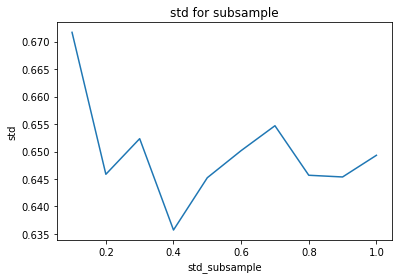

In [31]:
plt.plot(subsample_list_values, std_subsample)
plt.title('std for subsample')
plt.ylabel('std')
plt.xlabel('std_subsample')